In [1]:
import pandas as pd
from matplotlib import mlab
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import zipfile
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# show a little more information when printing data frame
pd.options.display.max_rows = 300
pd.options.display.max_seq_items = 300

plt.rcParams['figure.figsize'] = [10, 7] # make plots a little bigger



Infection_rate_threshold = .23

## Download the data

If the data can't be readily downloaded, default to local file

In [2]:
url = 'https://www.kaggle.com/davidbnn92/weather-data-for-covid19-data-analysis/download'
file = '/home/dustin/School/DM/Project/data.zip'
csv_name = 'training_data_with_weather_info_week_4.csv'

df = None

try:
    urllib.request.urlretreive(url, file)
    zf = zipfile.ZipFile(file)
    df = pd.read_csv(zf.open(csv_name, parse_dates=True))
    print('Successfully retreived data')

except: 
    df = pd.read_csv(csv_name, parse_dates=True)
    print('Defaulted to local data set')


Defaulted to local data set


In [3]:
df = pd.read_csv('training_data_with_weather_info_week_4.csv', parse_dates=True)

df

,Id,Country_Region,Province_State,Date,ConfirmedCases,Fatalities,country+province,Lat,Long,day_from_jan_first,...,min,max,stp,slp,dewp,rh,ah,wdsp,prcp,fog
0,1,Afghanistan,NaN,2020-01-22,0.0,0.0,Afghanistan-,33.000000,65.000000,22,...,33.6,54.9,999.9,1024.3,27.4,0.545709,0.186448,9.4,0.00,0
1,2,Afghanistan,NaN,2020-01-23,0.0,0.0,Afghanistan-,33.000000,65.000000,23,...,32.7,55.9,999.9,1020.8,22.8,0.461259,0.163225,14.9,99.99,1
2,3,Afghanistan,NaN,2020-01-24,0.0,0.0,Afghanistan-,33.000000,65.000000,24,...,36.9,43.2,999.9,1018.6,34.5,0.801794,0.325375,10.4,0.17,1
3,4,Afghanistan,NaN,2020-01-25,0.0,0.0,Afghanistan-,33.000000,65.000000,25,...,37.9,56.3,999.9,1018.0,37.8,0.728175,0.214562,6.1,0.57,1
4,5,Afghanistan,NaN,2020-01-26,0.0,0.0,Afghanistan-,33.000000,65.000000,26,...,36.1,53.1,999.9,1014.8,33.2,0.685513,0.231656,10.8,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24409,35642,Zimbabwe,NaN,2020-04-04,9.0,1.0,Zimbabwe-,-17.829167,31.052222,95,...,66.2,80.6,999.9,NaN,53.9,0.481730,0.130122,4.2,0.00,0
24410,35643,Zimbabwe,NaN,2020-04-05,9.0,1.0,Zimbabwe-,-17.829167,31.052222,96,...,66.2,80.6,999.9,NaN,53.9,0.481730,0.130122,4.2,0.00,0
24411,35644,Zimbabwe,NaN,2020-04-06,10.0,1.0,Zimbabwe-,-17.829167,31.052222,97,...,66.2,80.6,999.9,NaN,53.9,0.481730,0.130122,4.2,0.00,0
24412,35645,Zimbabwe,NaN,2020-04-07,11.0,2.0,Zimbabwe-,-17.829167,31.052222,98,...,66.2,80.6,999.9,NaN,53.9,0.481730,0.130122,4.2,0.00,0


# Data Preparation

## What are we going to add to the data?

### Rates of change

We group on the location, then we sort on the date, and we get a previous rate of change for the time stamps **ConfirmedCases** and we label it as **Infection_rate**. Then we calculate some more information based on **Infection_rate** such as the max, min, and average, and we append those statistics to all of the grouped rows. 

### Data filtering

We also take a look for bad data vlaues, and we may drop some rows if the information isnt complete.

In [4]:
list(df)

['Id',
 'Country_Region',
 'Province_State',
 'Date',
 'ConfirmedCases',
 'Fatalities',
 'country+province',
 'Lat',
 'Long',
 'day_from_jan_first',
 'temp',
 'min',
 'max',
 'stp',
 'slp',
 'dewp',
 'rh',
 'ah',
 'wdsp',
 'prcp',
 'fog']

In [5]:
# initial sort, group by country/province and then order by date
df.sort_values(by=['country+province', 'Date'])

# pct: previous item rate of change, here we get a single rate of change for one date to another
df['Infection_rate'] = df.groupby(['country+province'])['ConfirmedCases'].pct_change()

# some countries test a person positive, but then a few days later it was apparently a mistake? ignoring negative differences in "confirmed" cases
df.loc[df['Infection_rate'] < 0, 'Infection_rate'] = 0

# use this as categorical data for later
df['High_Infection_rate'] = df['Infection_rate'] >= Infection_rate_threshold

# change the defaults for some things, this messes up some models

# apparently for some columns if a value was missing a 999.9 was put instead, lets just filter those. 
#for col in ['stp', 'wdsp']:
#    df[col].replace(999.9, np.inf, inplace=True)

# get rid of any inf values
df.replace(np.inf, np.NaN, inplace=True)

# we dont want 0's counted when doing the mean for 
# infection rates, being np.NaN they will be ignored.
# this may destroy the knowledge of what was originally 0, I don't think we are too interested in what was 0 and
# what wasn't for this, we might come back to this later
df.loc[df['Infection_rate'] == 0, 'Infection_rate'] = np.NaN

df = df.join(df.groupby('country+province')['Infection_rate'].mean().rename('average_infection_rate').to_frame(), on='country+province')

df = df.join(df.groupby('country+province')['Infection_rate'].min().rename('min_infection_rate').to_frame(), on='country+province')


df = df.join(df.groupby('country+province')['Infection_rate'].max().rename('max_infection_rate').to_frame(), on='country+province')

df = df.join(df.groupby('country+province')['fog'].mean().rename('fog_rate').to_frame(), on='country+province')



# we dont really care about countries that have 0 confirmed cases (NAN), and sometimes we want 
# to also not have NAN for the weather attributes, this code section can be fiddled with

df.loc[df['ConfirmedCases'] == 0, 'ConfirmedCases'] = np.NaN

cols = ['Id', 'Date', 'ConfirmedCases', 'Fatalities', 'Lat', 'Long', 'day_from_jan_first', 'ConfirmedCases']
for col in cols:
    df = df[df[col].notna()]


print(list(df))

print("-----------------------------")
print(df['Infection_rate'].describe(percentiles = [x / 100 for x in range(25, 100, 5)]))


['Id', 'Country_Region', 'Province_State', 'Date', 'ConfirmedCases', 'Fatalities', 'country+province', 'Lat', 'Long', 'day_from_jan_first', 'temp', 'min', 'max', 'stp', 'slp', 'dewp', 'rh', 'ah', 'wdsp', 'prcp', 'fog', 'Infection_rate', 'High_Infection_rate', 'average_infection_rate', 'min_infection_rate', 'max_infection_rate', 'fog_rate']
-----------------------------
count    7405.000000
mean        0.309381
std         0.666731
min         0.000015
25%         0.067251
30%         0.080951
35%         0.095238
40%         0.111111
45%         0.127291
50%         0.146310
55%         0.168261
60%         0.195196
65%         0.222222
70%         0.259411
75%         0.312834
80%         0.375000
85%         0.500000
90%         0.649696
95%         1.000000
max        22.000000
Name: Infection_rate, dtype: float64


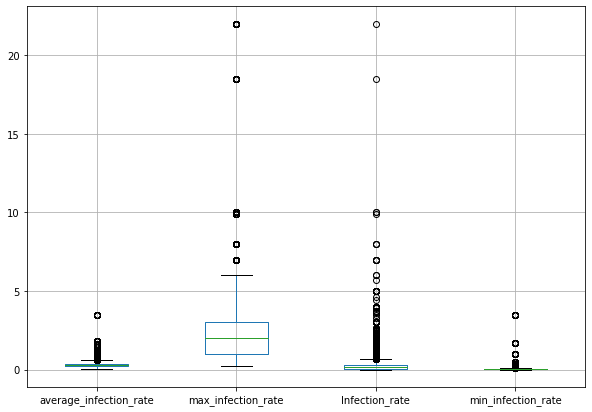

In [6]:
df.boxplot(column=['average_infection_rate', 'max_infection_rate', 'Infection_rate', 'min_infection_rate'])

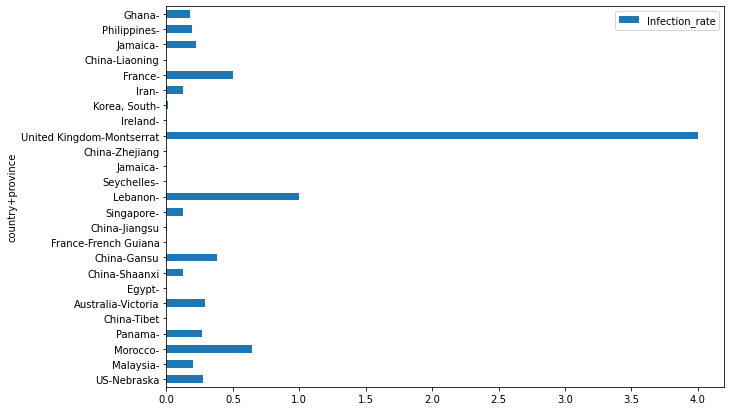

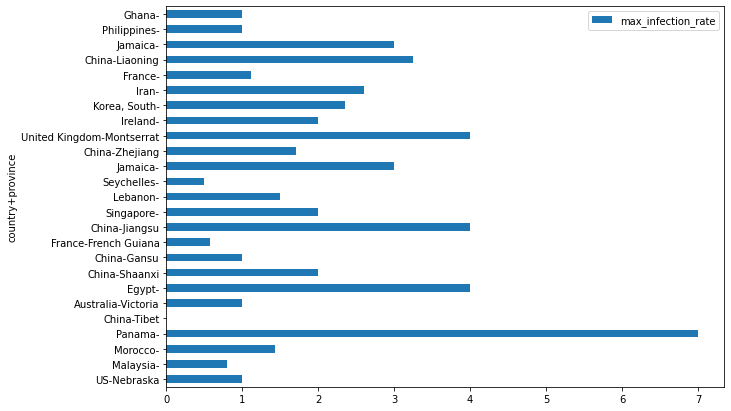

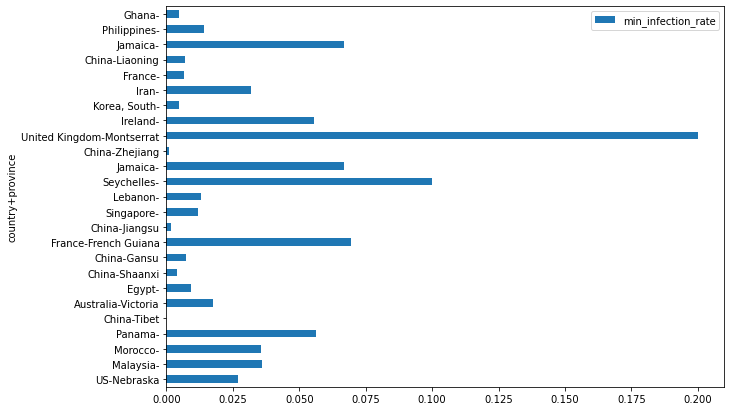

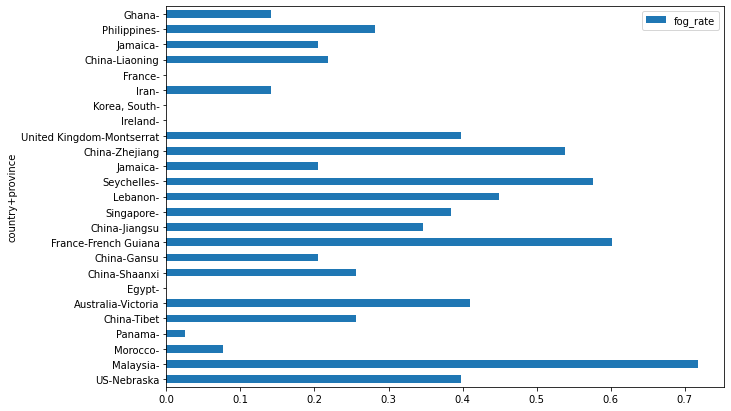

In [7]:
df.sample(n=25, random_state=1).plot.barh(x='country+province', y='Infection_rate', rot=0)
df.sample(n=25, random_state=1).plot.barh(x='country+province', y='max_infection_rate', rot=0)
df.sample(n=25, random_state=1).plot.barh(x='country+province', y='min_infection_rate', rot=0)
df.sample(n=25, random_state=1).plot.barh(x='country+province', y='fog_rate', rot=0)

plt.show(block=True)

In [8]:
try:
    df.to_csv(r'processed_data.csv', index = False)
    print('Saved processed data')
    print('Num Instances: ' + str(len(df)))
    print("Data Columns")
    print(list(df))
except:
    print('Could not save processed data')

Saved processed data
Num Instances: 11939
Data Columns
['Id', 'Country_Region', 'Province_State', 'Date', 'ConfirmedCases', 'Fatalities', 'country+province', 'Lat', 'Long', 'day_from_jan_first', 'temp', 'min', 'max', 'stp', 'slp', 'dewp', 'rh', 'ah', 'wdsp', 'prcp', 'fog', 'Infection_rate', 'High_Infection_rate', 'average_infection_rate', 'min_infection_rate', 'max_infection_rate', 'fog_rate']


Count of high infection rates:
First Half:	1094
Second Half:	1724


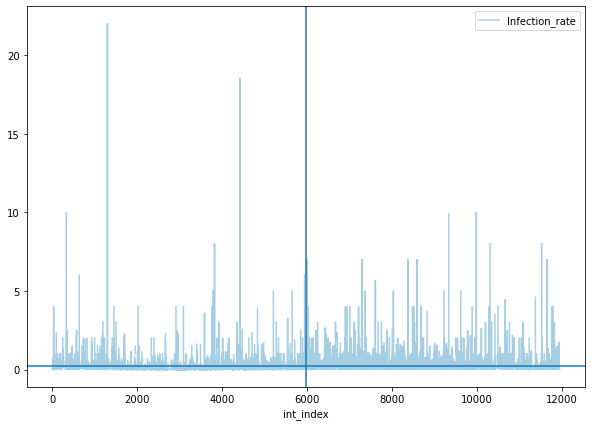

In [9]:
# sort values in data frame

df_copy = df.sort_values(by=['fog_rate'],
                        ascending=[True])

first, second = np.array_split(df, 2)

first = first.sort_values(by=['temp'],
                        ascending=[False])

second = second.sort_values(by=['temp'],
                        ascending=[True])
df_copy = pd.concat([first, second])

df_copy['int_index'] = range(len(df_copy))


ax = df_copy.plot(x='int_index', y='Infection_rate', colormap='Paired')
ax.axhline(y=Infection_rate_threshold)
ax.axvline(x=len(df_copy) // 2)

print("Count of high infection rates:")
print("First Half:\t" + str(df_copy.head(len(df_copy) // 2)['High_Infection_rate'].sum()))
print("Second Half:\t" + str(df_copy.tail(len(df_copy) // 2)['High_Infection_rate'].sum()))